In [ ]:
!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 63.8 MB/s eta 0:00:00


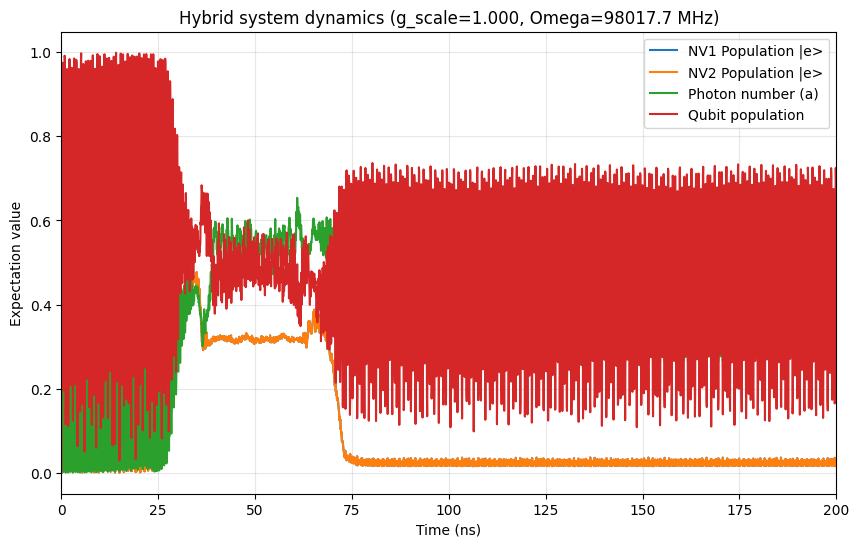

In [ ]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


# Units & constants
GHz = 1e9
ns = 1e-9
two_pi = 2 * np.pi


# Parameters (original values)
g_a_orig = g_b_orig = 26 * two_pi * GHz
g1_orig = g2_orig = 7 * two_pi * GHz

omega_a = omega_b = 2.8 * 10 * two_pi * GHz

omega_eg = omega_ge1 = omega_ge2 = 2.8 * 10 * two_pi * GHz

omega_gu1 = omega_gu2 = 3.8 * 2 * two_pi * GHz


# If you want realistic (very fast) dynamics use g_scale = 1.0
# For easier visualization in ns-scale, reduce coupling (e.g. 0.05 - 0.2)
g_scale = 1

g_a = g_scale * g_a_orig
g_b = g_scale * g_b_orig
g1 = g_scale * g1_orig
g2 = g_scale * g2_orig

# Detunings (rad/s)
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2


# Time axis (use ns for plotting)
t_max_ns = 200.0              # ns (more time to see slow envelope)
n_points = 3000
times = np.linspace(0, t_max_ns * ns, n_points)


# Hilbert space and operators
def tensor_op(*ops):
    return qt.tensor(*ops)

# Mode dims: resonator a (2), resonator b (2), qubit (2), NVE1 (3), NVE2 (3)
a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))

# Transmon/qubit as two-level sigma
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

# NV-center operator builder
def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

# NV1 (index 3), NV2 (index 4)
S1_ge_plus  = S_op(3, 1, 0, 3)
S1_ge_minus = S_op(3, 0, 1, 3)
S1_gu_plus  = S_op(3, 2, 0, 3)
S1_gu_minus = S_op(3, 0, 2, 3)

S2_ge_plus  = S_op(3, 1, 0, 4)
S2_ge_minus = S_op(3, 0, 1, 4)
S2_gu_plus  = S_op(3, 2, 0, 4)
S2_gu_minus = S_op(3, 0, 2, 4)


# Drive pulse (Gaussian envelope) and amplitude
t0 = 50 * ns
sigma_t = 10 * ns

def gauss_env(t):
    return np.exp(-((t - t0) ** 2) / (2 * sigma_t ** 2))

# Rabi amplitude (choose relative to g_a)
Omega = 0.6 * abs(g_a)   # drive strength in same units (rad/s)
# For smaller drive, reduce Omega; for purely coupling-driven dynamics set Omega=0


# Time-dependent Hamiltonian (include coupling coefficients)
# Each entry: [operator, coeff(t, args)]
H_t = [
    # resonator <-> qubit (Jaynes-Cummings type), include g_a/g_b
    [g_a * a * sigma_plus,  lambda t, args: np.exp(1j * delta_a * t)],
    [g_a * a.dag() * sigma_minus, lambda t, args: np.exp(-1j * delta_a * t)],
    [g_b * b * sigma_plus,  lambda t, args: np.exp(1j * delta_b * t)],
    [g_b * b.dag() * sigma_minus, lambda t, args: np.exp(-1j * delta_b * t)],

    # NV1 couplings (use g1)
    [g1 * a * S1_ge_plus,  lambda t, args: np.exp(1j * delta1_ge * t)],
    [g1 * a.dag() * S1_ge_minus, lambda t, args: np.exp(-1j * delta1_ge * t)],
    [g1 * a * S1_gu_plus,  lambda t, args: np.exp(1j * delta1_gu * t)],
    [g1 * a.dag() * S1_gu_minus, lambda t, args: np.exp(-1j * delta1_gu * t)],

    # NV2 couplings (use g2)
    [g2 * b * S2_ge_plus,  lambda t, args: np.exp(1j * delta2_ge * t)],
    [g2 * b.dag() * S2_ge_minus, lambda t, args: np.exp(-1j * delta2_ge * t)],
    [g2 * b * S2_gu_plus,  lambda t, args: np.exp(1j * delta2_gu * t)],
    [g2 * b.dag() * S2_gu_minus, lambda t, args: np.exp(-1j * delta2_gu * t)],

    # Classical Gaussian drive on resonators (with real amplitude Omega)
    [a,     lambda t, args: (Omega * gauss_env(t)) * np.exp(1j * delta_a * t)],
    [a.dag(), lambda t, args: np.conj((Omega * gauss_env(t)) * np.exp(1j * delta_a * t))],
    [b,     lambda t, args: (Omega * gauss_env(t)) * np.exp(1j * delta_b * t)],
    [b.dag(), lambda t, args: np.conj((Omega * gauss_env(t)) * np.exp(1j * delta_b * t))],
]


# Decoherence (kept small so oscillations persist)
kappa = 1 / (20e-6)   # resonator decay (1/s)
gamma_q = 1 / (20e-6) # qubit relaxation
gamma_phi_q = 1 / (200e-6) # qubit pure dephasing a bit smaller

c_ops = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi_q) * (sigma_plus * sigma_minus)
]

# Initial state: photon vacuum, qubit ground, NVs ground
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)

# Observables (projectors for NVE excited populations)

pop_NVE1_e = S_op(3, 1, 1, 3)
pop_NVE2_e = S_op(3, 1, 1, 4)

photon_a = a.dag() * a
qubit_pop = sigma_plus.dag() * sigma_plus

e_ops = [pop_NVE1_e, pop_NVE2_e, photon_a, qubit_pop]


# Run solver
result = qt.mesolve(H_t, psi0, times, c_ops, e_ops=e_ops)


# Plot results (time in ns)
plt.figure(figsize=(10,6))
plt.plot(times/ns, result.expect[0], label="NV1 Population |e>")
plt.plot(times/ns, result.expect[1], label="NV2 Population |e>")
plt.plot(times/ns, result.expect[2], label="Photon number (a)")
plt.plot(times/ns, result.expect[3], label="Qubit population")

plt.xlabel("Time (ns)")
plt.ylabel("Expectation value")
plt.legend()
plt.title(f"Hybrid system dynamics (g_scale={g_scale:.3f}, Omega={Omega/1e6:.1f} MHz)")
plt.xlim(0, t_max_ns)
plt.grid(alpha=0.3)
plt.show()
